In [1]:
%pip install numpy pandas tensorflow[and-cuda] matplotlib scikit-learn keras-tuner ipympl pydantic
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

if not os.path.exists("./figures"):
    os.mkdir("./figures")

# test GPU found
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Note: you may need to restart the kernel to use updated packages.


2023-12-18 22:54:07.927617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 22:54:07.927654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 22:54:07.928986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 22:54:07.934708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 22:54:08.524451: W tensorflow/compiler/tf2

Num GPUs Available:  1


2023-12-18 22:54:09.144107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:54:09.178803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:54:09.179007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
ENCODING = locale.getpreferredencoding()

DF_PATH = "HEL_12-10-21to08-11-23.csv"
#DF_PATH = "HEL_12-10-21to08-11-23_timedelta.csv"

TUNER_DIRECTORY = "./keras-tuner-dir-transformer"

SELECTED_TICKERS = json.load(open("./TICKERS_TO_FOLLOW.json", "r", encoding=ENCODING))
# Remove the .HE ending from the tickers
SELECTED_TICKERS = [ticker[:-3] if ticker.endswith(".HE") else ticker for ticker in SELECTED_TICKERS]
# Convert the ticker names to real names
TICKER_NAME_TO_REAL_NAME = json.load(open("./ticker_to_real_name.json", "r", encoding=ENCODING))

DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
# If the column has ".HE" ending, remove it
DATAFRAME.columns = [col[:-3] if col.endswith(".HE") else col for col in DATAFRAME.columns]

HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
#index conversion maps the index of a ticker in the dataframe to the ticker name
INDEX_TO_TICKER = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
INDEX_TO_TICKER = {i: ticker for i, ticker in enumerate(INDEX_TO_TICKER.values())}

INDEX_TO_REAL_NAME = {i: TICKER_NAME_TO_REAL_NAME[ticker] for i, ticker in enumerate(INDEX_TO_TICKER.values())}

# How much data to use for testing, so not used in hyperparameter tuning
TEST_FRAC = 0.2

# Number of hours of past data to use for prediction
MHOURS = 48

# What percentual change in price is considered a change
CHANGE_THRESHOLD = 0.002


print("Selected tickers: \n")
for i,name in INDEX_TO_REAL_NAME.items():
    print(f"{INDEX_TO_TICKER[i]}: {name}")
print()

print("Dataframe shape: ", DATAFRAME.shape)
print(f"Using Time Delta: {HAS_TIMEDELTA}")
    

Selected tickers: 

REG1V: Revenio Group
NESTE: Neste
ORNBV: Orion B
KNEBV: Kone B
OLVAS: Olvi A
HUH1V: Huhtamäki
DETEC: Detection Technology
ORNAV: Orion A
CGCBV: Cargotec Corp
VAIAS: Vaisala
ALBBV: Ålandsbanken
VALMT: Valmet
EQV1V: eQ
PON1V: Ponsse

Dataframe shape:  (4389, 14)
Using Time Delta: False


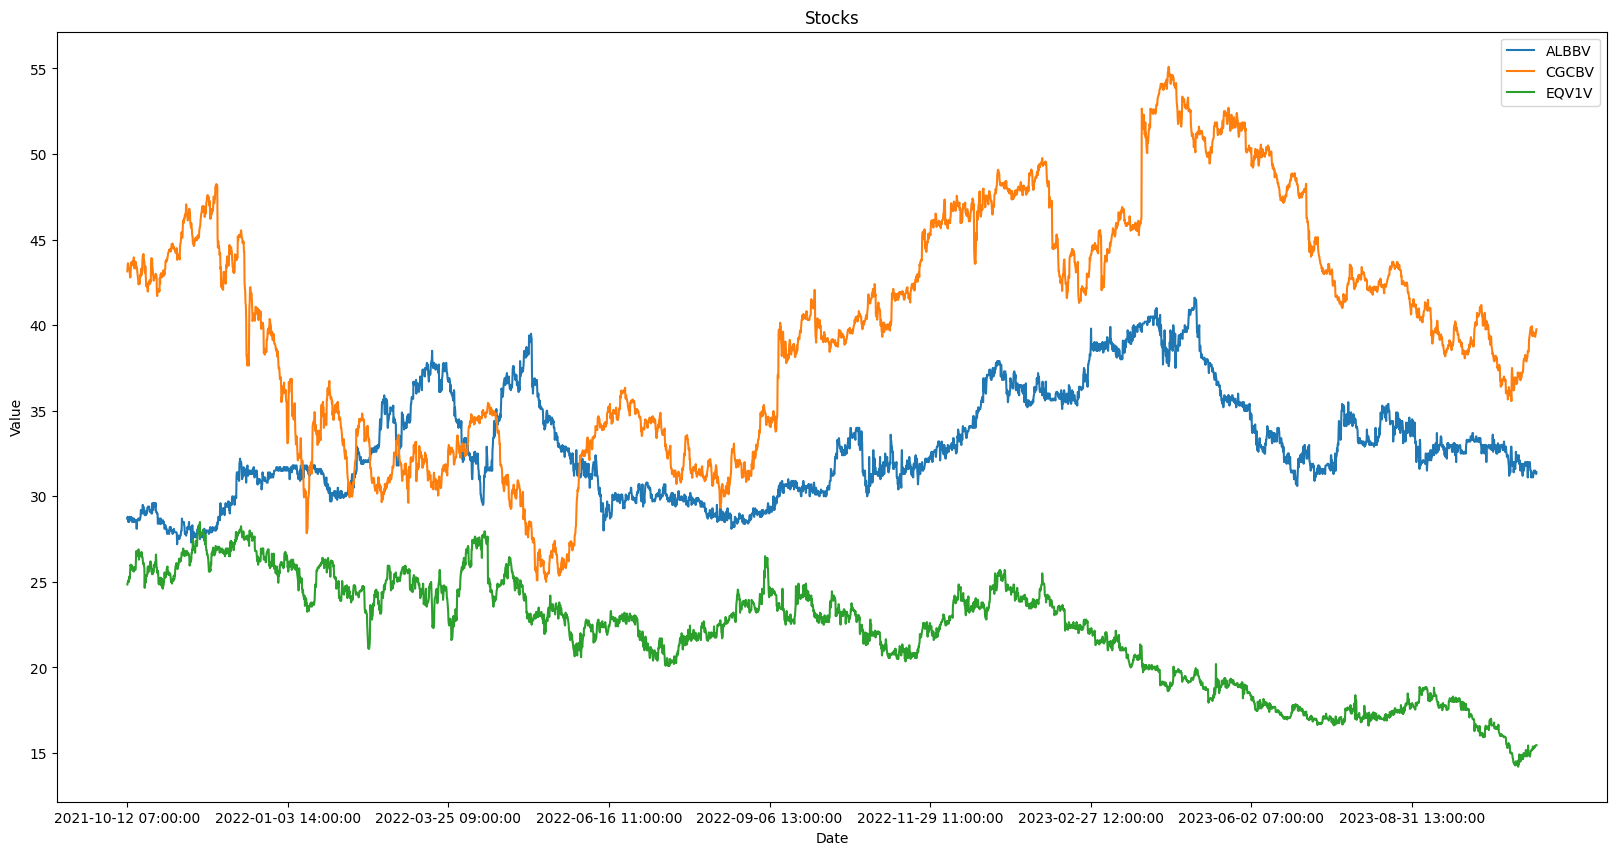

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [4]:
# In this cell, we create the transformed dataframe, so the dataframe that is used to create batches for the model
def create_diff_df(df, inplace=False):
    """ Create a dataframe where the values are the difference between the current and previous value.
    The timedelta column is not differenced, and the shape of the dataframe is maintained by copying the second row to the first row.
    """
    if not inplace:
        df = df.copy()
    if HAS_TIMEDELTA:
        timedelta_col = df["Time Delta"]
    df = df.diff()
    
    # Copy the second row to the first row, since diff leaves a nan first row
    df = df.fillna(df.iloc[1])
    
    # Add the timedelta column back
    if HAS_TIMEDELTA:
        df["Time Delta"] = timedelta_col
    
    return df

TRANSFORMED_DF = create_diff_df(DATAFRAME, inplace=False)
    

# Now the transformed_df contains the data that is usedto make inputs to the model
print(f"Dataframe shape: {DATAFRAME.shape}")
print(f"Transformed dataframe shape: {TRANSFORMED_DF.shape}")


Dataframe shape: (4389, 14)
Transformed dataframe shape: (4389, 14)


In [5]:
# Reload modules
%load_ext autoreload
%autoreload 2
from stock_modules.stock_transform import create_batch_xy, create_transformer_onehot_xy

def update_global_mhours(new_mhours):
    """ Update the global variables X_train, Y_train, X_test, Y_test, X_og, Y_og, MHOURS
    """
    
    global MHOURS, X_train, Y_train, X_test, Y_test, X, Y, X_ts, X_ts_train, X_ts_test
    MHOURS = new_mhours
    print(f"MHOURS is now {MHOURS}")
    print(f"Recalculating X and Y data...")
    # Batch X data into sequences of length MHOURS (from T to T+n)
    # Label Y data as 0, 1, 2 for down, flat, up
    # We give the data in the original format, so that the labels can be calculated
    _, Y = create_batch_xy(MHOURS,
                        DATAFRAME,
                        overlap=True,
                        y_updown=False,
                        y_direction=True,
                        threshold=CHANGE_THRESHOLD,
                        to_onehot=True,
                        create_labels=True,
                        )

    # Here instead, we can give the differenced data, because we don't need to calculate the labels
    X,_ = create_batch_xy(MHOURS,
                            TRANSFORMED_DF,
                            overlap=True,
                            create_labels=False,
                            )
    
    _, X_ts, _ = create_transformer_onehot_xy(MHOURS-1,TRANSFORMED_DF.values, DATAFRAME.values, timestamps_np=DATAFRAME.index.values)
    # Remove the last row of X_ts, since it is not used
    X_ts = X_ts[:-1,:,:]

    # Swap 2nd and 3rd axes in Y to reshape it to (n_samples, 3, nstocks)
    Y = np.swapaxes(Y, 1, 2)

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    test_sz = int(X.shape[0] * TEST_FRAC)

    # Split the data into train and test sets
    X_train = X[:-test_sz,:,:]
    Y_train = Y[:-test_sz,:,:]
    X_ts_train = X_ts[:-test_sz,:,:]
    X_test = X[-test_sz:,:,:]
    Y_test = Y[-test_sz:,:,:]
    X_ts_test = X_ts[-test_sz:,:,:]
    
    return

update_global_mhours(MHOURS)

print(f"Example input has shape {X_train[0].shape} and looks like: \n{X_train[0]}\n")
print(f"Example output has shape {Y_train[0].shape} and looks like: \n{Y_train[0]}\n")
print(f"X_ts has shape {X_ts.shape} and looks like: \n{X_ts[0]}\n")

# Count the number of ups/downs/flats in Y_train
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")


MHOURS is now 48
Recalculating X and Y data...
[[55.95000076 41.81999969 35.68999863 ... 36.45999908 24.85000038
  39.15000153]
 [55.79999924 41.72000122 35.63000107 ... 36.59999847 24.95000076
  39.20000076]
 [55.70000076 42.06000137 35.40000153 ... 36.40000153 25.
  39.5       ]
 ...
 [22.81999969 31.82999992 36.90999985 ... 22.60000038 15.43999958
  24.        ]
 [22.89999962 31.84000015 37.13000107 ... 22.65999985 15.46000004
  23.70000076]
 [23.02000046 31.89999962 37.18999863 ... 22.78000069 15.46000004
  24.04999924]]

            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4341, 48, 14)) and 'Y' ((4341, 14, 3))
            
[[-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.09999847  0.34000015 -0.22999954 ... -0.19999695  0.04999924
   0.29999924]
 ...
 [-0.04000092  0.29999924  0.00999832 ...  0.01000023  0.0199995
  -0.10000038]
 [ 0.07999992  0.0

2023-12-18 22:54:11.020287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:54:11.020472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:54:11.020609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
from stock_modules.stock_ml import (SkipTDLoss, MultiSoftmaxLoss, MultiAccuracy)
from invest_strategies import strategy_mask_from_direction_model, calculate_profit_on_invest_strategy
from stock_modules.stock_transformer import (DataEmbedding,
                                             Encoder,
                                             Decoder)

#from pydantic import Field, PositiveInt, UnitFloat
#from typing_extensions import Annotated

create_loss_fun = lambda: MultiSoftmaxLoss() if not HAS_TIMEDELTA else SkipTDLoss(MultiSoftmaxLoss())


def create_transformer_model(m, n,
                output_dim=3,
                head_size=16,
                num_heads=16,
                ff_dim=32,
                num_transformer_blocks=1,
                mlp_units=(64,),
                dropout=0.01,
                mlp_dropout=0.,
                class_first=False):
    input_shape = (m,n)

    # Input declaration -> [BxLxN, BxLx1]
    context = tf.keras.Input(shape=input_shape)
    context_ts = tf.keras.Input(shape=(m,4))
    inputs = tf.keras.Input(shape=input_shape)
    input_ts = tf.keras.Input(shape=(m,4))

    # Encoder layers -> BxLxC
    x = DataEmbedding(head_size)([context, context_ts])
    for _ in range(num_transformer_blocks):
        x = Encoder(head_size, num_heads, ff_dim, dropout)(x)

    # Decoder layers -> BxLxC
    y = DataEmbedding(head_size)([inputs, input_ts])
    for _ in range(num_transformer_blocks):
        y = Decoder(head_size, num_heads, ff_dim, dropout)([y,x])

    # Output layers -> BxNx3
    y = tf.keras.layers.Conv1DTranspose(filters=n, kernel_size=3, padding="same")(y)
    y = tf.keras.layers.Permute((2,1))(y)
    for dim in mlp_units:
        y = tf.keras.layers.Dense(dim, activation="relu")(y)
        y = tf.keras.layers.Dropout(mlp_dropout)(y)
    outputs = tf.keras.layers.Dense(output_dim, activation="linear")(y)

    if class_first:
        outputs = tf.keras.layers.Permute((2,1))(outputs)

    return tf.keras.Model([context,context_ts,inputs,input_ts],outputs)

def create_direction_pred_model(hp):
    """ Create a model that predicts the direction of the stock price change
    """
    m = X_train.shape[1]
    n = X_train.shape[2]
    output_dim = 3
    head_size = hp.Choice("head_size", values=[8,16,32])
    num_heads = hp.Choice("num_heads", values=[8,16,32])
    ff_dim = hp.Choice("ff_dim", values=[16,32,64])
    num_transformer_blocks = hp.Choice("num_transformer_blocks", values=[1,2,3])
    mlp_units = hp.Choice("mlp_units", values=[32,64,128])
    dropout = hp.Choice("dropout", values=[0.0,0.01,0.05,0.1])
    mlp_dropout = hp.Choice("mlp_dropout", values=[0.0,0.1,0.2,0.3])
    class_first = True
    model = create_transformer_model(m,n,
                                    output_dim=output_dim,
                                    head_size=head_size,
                                    num_heads=num_heads,
                                    ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks,
                                    mlp_units=(mlp_units,),
                                    dropout=dropout,
                                    mlp_dropout=mlp_dropout,
                                    class_first=class_first)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss=create_loss_fun(),
                  metrics=[MultiAccuracy()])
    return model

        

In [7]:
class CalcProfitCallback(tf.keras.callbacks.Callback):
    """ Calculates the profit on validation data after each epoch.
    """
    def __init__(self, prices):
        super().__init__()
        print(f"Received prices with shape: {prices.shape}")
        self.prices = prices
        self.diff_data = create_diff_df(prices, inplace=False).values
        self.prices = prices.values
        self.profits = []
        #print(f"Shape of xdata: {self.xdata.shape}")
        print(f"Shape of prices: {self.prices.shape}")
    
    def on_epoch_end(self, epoch, logs=None):
        mask = strategy_mask_from_direction_model(self.diff_data, MHOURS, self.model)
        #print(f"Mask shape: {mask.shape}")
        profit = calculate_profit_on_invest_strategy(self.prices, mask)
        self.profits.append(profit)
        # Add the profit to the logs, so we can use it in hp tuning
        if logs is not None:
            logs["profit"] = profit

In [11]:
%load_ext autoreload
%autoreload 2
# Tune the hyperparameters
import keras_tuner as kt
from analyze_hyperopt_folder import get_best_trial


DO_HYPERPARAMETER_TUNING = True
PATIENCE = 20
EPOCHS = 200
BATCH_SIZE = 128
PROJECT_NAME = f"direction_prediction_{MHOURS}"
PROJECT_NAME += "_td" if HAS_TIMEDELTA else ""
TENSORBOARD_LOG_DIR = f"./tb-logs-transformer/{PROJECT_NAME}"
HP_SEARCH_VALIDATION_SPLIT = 0.15


if DO_HYPERPARAMETER_TUNING:
    # Create a tuner
    objective = kt.Objective("val_loss", direction="min")
    #objective = kt.Objective("val_multi_accuracy", direction="max")
    #objective = kt.Objective("profit", direction="max")
    PROJECT_NAME += "_" + objective.name
    print(f"Starting hyperparameter tuning with project name: {PROJECT_NAME}")
    tuner = kt.Hyperband(create_direction_pred_model,
                        objective=objective,
                        max_epochs=EPOCHS,
                        factor=3,
                        directory=TUNER_DIRECTORY,
                        project_name=PROJECT_NAME,
                        )
    
    # Keep the data ordered, so the validation data is completely separate from the training data
    val_start_index = -int(X_train.shape[0] * HP_SEARCH_VALIDATION_SPLIT)
    
    xval = X_train[val_start_index:,:,:]
    yval = Y_train[val_start_index:,:,:]
    
    x_ts_val = X_ts_train[val_start_index:,:,:]
    X_train = X_train[:val_start_index,:,:]
    Y_train = Y_train[:val_start_index,:,:]
    X_ts_train = X_ts_train[:val_start_index,:,:]
    
    print(f"xval shape: {xval.shape}")
    print(f"yval shape: {yval.shape}")
    print(f"x_ts_val shape: {x_ts_val.shape}")
    print(f"X_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")
    print(f"X_ts_train shape: {X_ts_train.shape}")
    
    
    
    # To calculate the profit, we use data from DATFRAME, that corresponds with the validation data
    # So we take data after len(X_train), and until -len(X_test)
    train_end_idx = len(X_train)
    test_start_idx = -len(X_test)
    
    
    #profit_callback = CalcProfitCallback(DATAFRAME.iloc[train_end_idx:test_start_idx,:])
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=PATIENCE,
                                                    restore_best_weights=True,
                                                    mode="min")

    # Train the model
    tuner.search((X_train, X_ts_train, X_train, X_ts_train),
                 y = Y_train,
                epochs=200,
                batch_size=BATCH_SIZE,
                validation_data=((xval, x_ts_val, xval, x_ts_val), yval),
                callbacks=[early_stopping, tensorboard_callback],
                shuffle=True
                )

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    print(f"Found best model:")
    best_model.summary()
    # save the model
    best_model.save("best_model.h5")
    model = best_model
    
    directory = TUNER_DIRECTORY + "/" + PROJECT_NAME
    #best_acc_model, acc = get_best_trial(directory, metric="val_multi_accuracy", metric_mode = "max")
    #print(f"Best accuracy model: {best_acc_model}, accuracy: {acc}")
    #best_loss_model, loss = get_best_trial(directory, metric="val_loss", metric_mode = "min")
    #print(f"Best loss model: {best_loss_model}, loss: {loss}")
    #best_profit_model, profit = get_best_trial(directory, metric="profit", metric_mode = "max")
    #print(f"Best profit model: {best_profit_model}, profit: {profit}")
    
else:
    
    
    from stock_modules.stock_ml import create_transformer_model
    # Train a model once
    model = create_transformer_model(MHOURS, X_train.shape[2])
    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True),
                    loss=create_loss_fun(),
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)]
                    )
    print(model.summary())
    
    # If we train the model once, we can use the whole training set, including validation data
    # We use testing data as validation data

    # For profit callback we use the prices from -len(X_test) to the end
    
    #profit_callback = CalcProfitCallback(DATAFRAME.iloc[-len(X_test):,:])
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=PATIENCE,
                                                    restore_best_weights=True,
                                                    mode="min")    
    
    val_dataset = tf.data.Dataset.from_tensor_slices(((X_test, X_ts_test, X_test, X_ts_test), Y_test))
    print(f"Validation data sample: {next(iter(val_dataset))}")
    
    history = model.fit((X_train, X_ts_train, X_train, X_ts_train),
              y = Y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=((X_test, X_ts_test, X_test, X_ts_test), Y_test),
              callbacks=[early_stopping, tensorboard_callback],
              shuffle=True
              )
    print(f"Model trained, history: ")
    for k, v in history.history.items():
        print(f"{k}: {v}")

# Evaluate the model
loss, acc = model.evaluate((X_test, X_ts_test, X_test, X_ts_test), Y_test)
print(f"Test loss: {loss}, test accuracy: {acc}")

# Make predictions on the test data
Y_pred = model.predict((X_test, X_ts_test, X_test, X_ts_test))
# Remove the first column, since it is the timedelta column
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting hyperparameter tuning with project name: direction_prediction_48_val_loss
Reloading Tuner from ./keras-tuner-dir-transformer/direction_prediction_48_val_loss/tuner0.json
xval shape: (320, 48, 14)
yval shape: (320, 3, 14)
x_ts_val shape: (320, 48, 4)
X_train shape: (1815, 48, 14)
Y_train shape: (1815, 3, 14)
X_ts_train shape: (1815, 48, 4)
Found best model:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 14)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 48, 4)]              0         []                            
                                  

/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 11ms/step - loss: 1.0920 - multi_accuracy: 0.3754
Test loss: 1.0920195579528809, test accuracy: 0.3753916919231415
28/28 [==============================] - 0s 3ms/step


Revenio Group: 0.34
Neste: 0.34
Orion B: 0.39
Kone B: 0.47
Olvi A: 0.42
Huhtamäki: 0.31
Detection Technology: 0.35
Orion A: 0.43
Cargotec Corp: 0.43
Vaisala: 0.31
Ålandsbanken: 0.34
Valmet: 0.42
eQ: 0.37
Ponsse: 0.41
Total average accuracy: 0.38


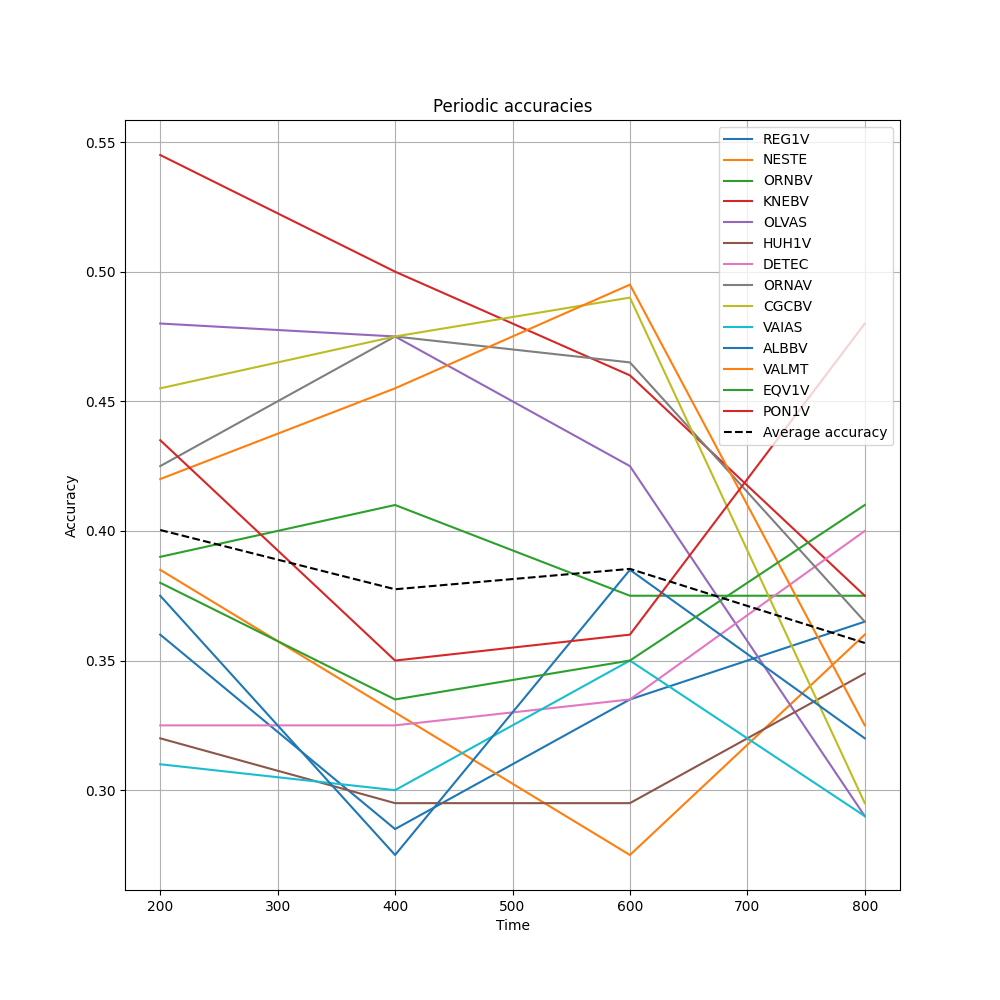

In [12]:
%matplotlib widget

# Calculate the accuracy on different time periods
TEST_PERIOD_LEN = 200

period_accuracies = []
# Take different 50 hour periods
periods_begin = list(range(0, len(Y_pred), TEST_PERIOD_LEN))
periods_end = list(range(TEST_PERIOD_LEN, len(Y_pred)+1, TEST_PERIOD_LEN))
for begin, end in zip(periods_begin, periods_end):
    Y_pred_upto = Y_pred[begin:end,:,:]
    Y_test_upto = Y_test[begin:end,:,:]
    
    accuracies = []
    # Calculate the accuracy for each stock
    for stock_idx in range(Y_pred_upto.shape[2]):
        # Take the argmaxes for each column
        preds = np.argmax(Y_pred_upto[:,:,stock_idx], axis=1)
        trues = np.argmax(Y_test_upto[:,:,stock_idx], axis=1)
        # Calculate the accuracy
        acc = np.mean(preds == trues)
        accuracies.append(acc)
    period_accuracies.append(accuracies)

average_accuracies = np.mean(period_accuracies, axis=1)

# Plot the periodic accuracies for each stock
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Periodic accuracies")
ax.set_xlabel("Time")
ax.set_ylabel("Accuracy")
# The x axis is the full elapsed time
x = np.arange(len(X_test))
stock_xs = periods_end
# For each stock we plot its accuracy (y) at each period_begin (x)
for stock_idx, ticker in INDEX_TO_TICKER.items():
    y = [acc[stock_idx] for acc in period_accuracies]
    ax.plot(stock_xs, y, label=ticker)
# Plot the average accuracy
ax.plot(stock_xs, average_accuracies, label="Average accuracy", color="black", linestyle="--")
ax.legend()
ax.grid()
# Print the average accuracy for each stock
average_accuracies_per_stock = np.mean(period_accuracies, axis=0)
for ticker, acc in zip(INDEX_TO_REAL_NAME.values(), average_accuracies_per_stock):
    print(f"{ticker}: {round(acc,2)}")
total_average_accuracy = np.mean(average_accuracies_per_stock)
print(f"Total average accuracy: {total_average_accuracy}")
plt.savefig(f"./figures/{PROJECT_NAME}_periodic_accuracies.png")
plt.show()

        
    


In [13]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_direction_model)

optimal_profits = []
model_profits = []
periods_begin = list(range(0, len(Y_pred), TEST_PERIOD_LEN))
periods_end = list(range(TEST_PERIOD_LEN, len(Y_pred)+1, TEST_PERIOD_LEN))
for begin, end in zip(periods_begin, periods_end):
    price_data = DATAFRAME.iloc[begin:end,:].values
    diff_data = TRANSFORMED_DF.iloc[begin:end,:].values
    
    print(f"Price data shape: {price_data.shape}")
    print(f"Diff data shape: {diff_data.shape}")
    
    # Calculate the optimal strategy
    optimal_strategy_mask = calculate_optimal_invest_strategy(price_data)
    # Calculate the mask by making predictions with the model
    model_strategy_mask = strategy_mask_from_direction_model(diff_data, MHOURS, model)
    
    print(f"Optimal strategy mask shape: {optimal_strategy_mask.shape}")
    print(f"Model strategy mask shape: {model_strategy_mask.shape}")

    per_stock_optimal_profits = []
    per_stock_model_profits = []
    for stock_idx in range(price_data.shape[1]):
        stock_price_data = price_data[:,stock_idx].reshape(-1,1)
        stock_optimal_mask = optimal_strategy_mask[:,stock_idx].reshape(-1,1)
        stock_model_mask = model_strategy_mask[:,stock_idx].reshape(-1,1)
        # Calculate the profit on the optimal strategy
        optimal_profit = calculate_profit_on_invest_strategy(stock_price_data, stock_optimal_mask)
        # Calculate the profit on the model strategy
        model_profit = calculate_profit_on_invest_strategy(stock_price_data, stock_model_mask)
        
        per_stock_optimal_profits.append(optimal_profit)
        per_stock_model_profits.append(model_profit)
    
    optimal_profits.append(per_stock_optimal_profits)
    model_profits.append(per_stock_model_profits)

# Plot the profits
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Profits")
ax.set_xlabel("Time")
ax.set_ylabel("Profit")
average_profits = np.mean(model_profits, axis=1)
stock_xs = periods_end
# For each stock we plot both its optimal profit and model profit
for stock_idx, ticker in INDEX_TO_TICKER.items():
    #optimal_y = [profit[stock_idx] for profit in optimal_profits]
    model_y = [profit[stock_idx] for profit in model_profits]
    #ax.plot(stock_xs, optimal_y, label=f"{ticker} optimal")
    ax.plot(stock_xs, model_y, label=f"{ticker} model")

# Plot the average profits
ax.plot(stock_xs, average_profits, label="Average model profit", color="black", linestyle="--")
ax.legend()
ax.grid()
average_profits_per_stock = np.mean(model_profits, axis=0)
print(f"Average profit in {TEST_PERIOD_LEN} hours per stock: ")
for ticker, profit in zip(INDEX_TO_REAL_NAME.values(), average_profits_per_stock):
    print(f"{ticker}: {round(profit,2)}")
    
full_mask = strategy_mask_from_direction_model(TRANSFORMED_DF.values, MHOURS, model)
full_profit = calculate_profit_on_invest_strategy(DATAFRAME.values, full_mask)

print(f"Full profit on test period: {full_profit}")

plt.show()



    

Price data shape: (200, 14)
Diff data shape: (200, 14)

            Batched 'histories_arr' ((200, 14)) to 'X'
            ((152, 48, 14)) and 'Y' ((152, 14, 3))
            


ValueError: in user code:

    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 48, 14) dtype=float32>]


Plotting period from 400 to 600 for stocks: [1 3 7 2]



            Batched 'histories_arr' ((200, 4)) to 'X'
            ((152, 48, 4)) and 'Y' ((152, 4, 3))
            
5/5 [==============================] - 0s 2ms/step


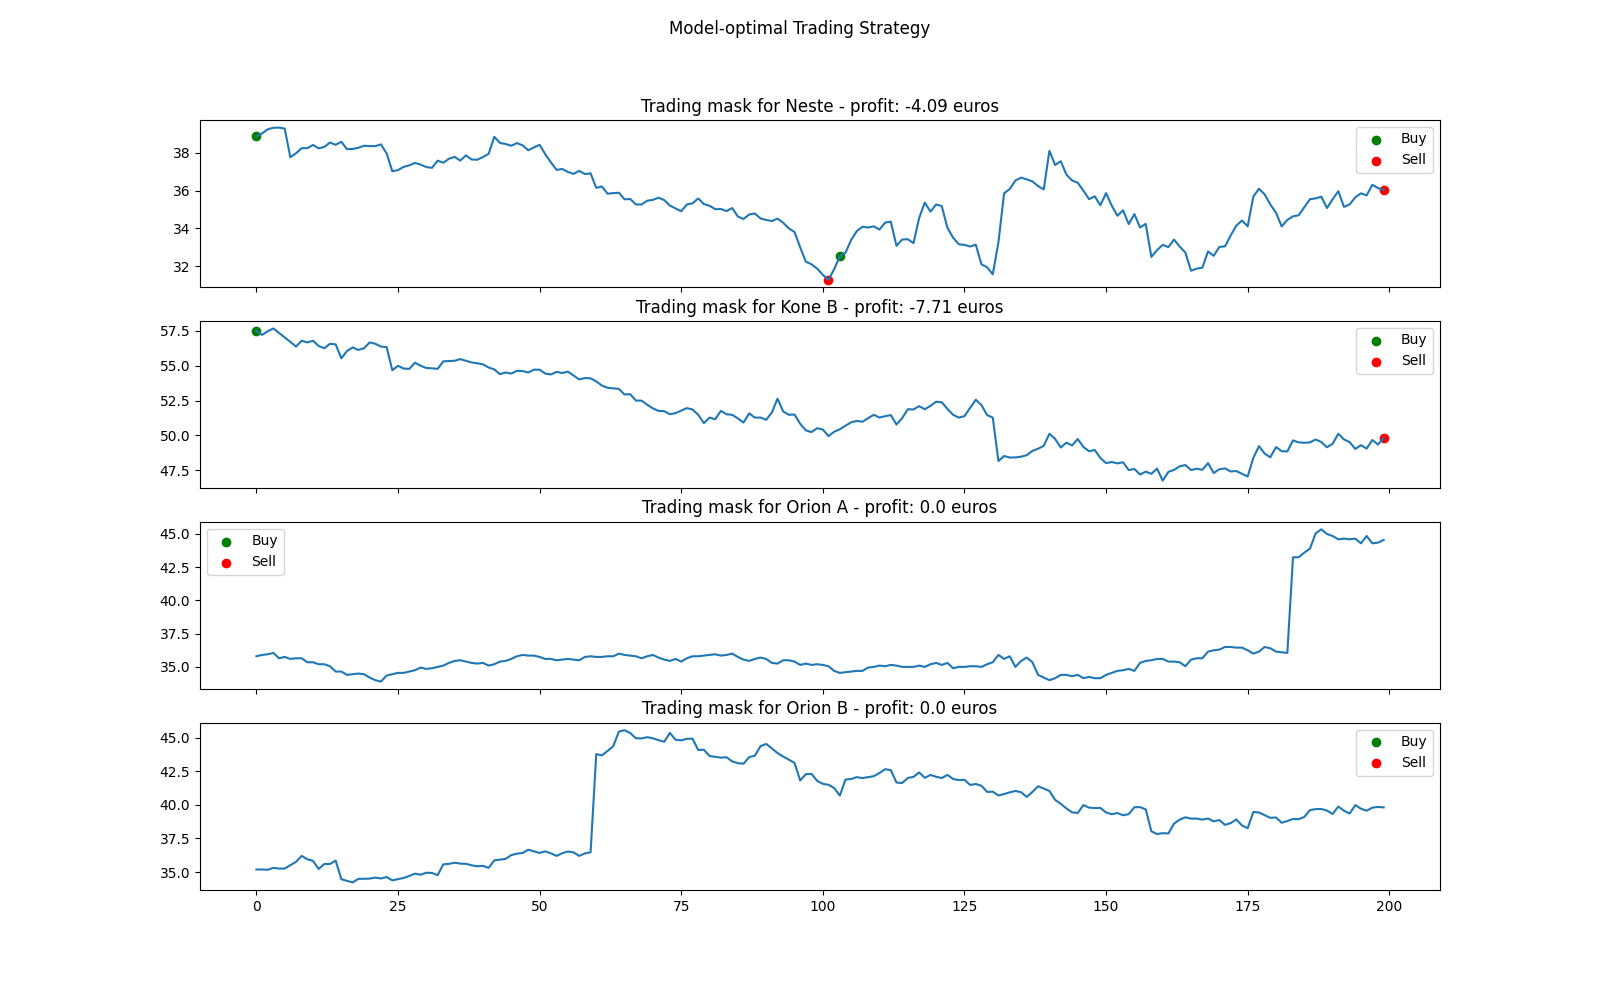

In [ ]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
# Plot the model's strategy on a random test period

# take 4 random stocks
stock_indices = np.random.choice(range(1,DATAFRAME.shape[1]), size=4, replace=False)
period_start = np.random.choice(periods_begin)
period_end = period_start + TEST_PERIOD_LEN

print(f"Plotting period from {period_start} to {period_end} for stocks: {stock_indices}")

transformed_data = TRANSFORMED_DF.iloc[period_start:period_end,:].values
price_data = DATAFRAME.iloc[period_start:period_end,:].values
transformed_data = transformed_data[:,stock_indices]
price_data = price_data[:,stock_indices]

mask = strategy_mask_from_direction_model(transformed_data, MHOURS, model)
fig,ax = plot_mask_and_data(mask, price_data, {i: INDEX_TO_REAL_NAME[si] for i,si in enumerate(stock_indices)})
fig.set_size_inches(10,10)